Howework 6- Justin Talbot

In [2]:
import wget
wget.download('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv')

100% [..........................................................................] 1423529 / 1423529

'housing (4).csv'

In [3]:
import pandas as pd
df_raw = pd.read_csv('housing.csv')

In [4]:
df = df_raw[
    df_raw['ocean_proximity'].isin(["INLAND","<1H OCEAN"])
]

In [5]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [6]:
df.total_bedrooms = df.total_bedrooms.fillna(0)

C:\Users\justin.talbot\Anaconda3\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [7]:
from sklearn.model_selection import train_test_split
import numpy as np

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [8]:
from sklearn.feature_extraction import DictVectorizer
features = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
               "median_income", "ocean_proximity"]

dv = DictVectorizer(sparse=True)
train_dict = df_train[features].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

Q1

In [9]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)



DecisionTreeRegressor(max_depth=1)

In [10]:
print(export_text(dt, feature_names=dv.feature_names_))


|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



Q2

In [11]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=10, random_state=1,n_jobs=-1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)

In [12]:
from sklearn import metrics
np.sqrt(metrics.mean_absolute_error(y_val, y_pred))

0.41024772023797856

Q3

In [13]:
scores = []
for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1,n_jobs=-1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    
    score = np.sqrt(metrics.mean_absolute_error(y_val, y_pred))
    
    scores.append((n,score))

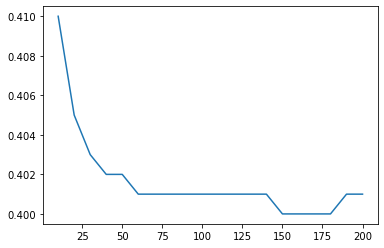

In [14]:
import matplotlib.pyplot as plt
df_scores = pd.DataFrame(scores, columns=['n','rmse'])
plt.plot(df_scores.n,df_scores.rmse.round(3))
plt.show()

Q4

In [15]:
scores = []
for depth in [10, 15, 20, 25]:
    rf = RandomForestRegressor(n_estimators=0, random_state=1,n_jobs=-1, max_depth=depth, warm_start=True)

    for n in range(10, 201, 10):
        rf.n_estimators = n
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)

        score = np.sqrt(metrics.mean_absolute_error(y_val, y_pred))

        scores.append((n,depth,score))

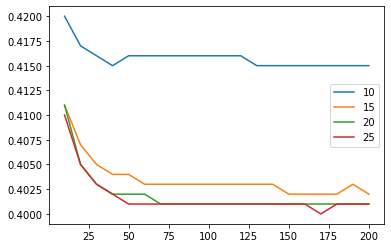

In [17]:
df_scores = pd.DataFrame(scores, columns=['n','depth','rmse'])
for depth in [10, 15, 20, 25]:
    df_sub = df_scores[df_scores.depth == depth]
    plt.plot(df_sub.n,df_sub.rmse.round(3), label = depth)
    
plt.legend()
plt.show()

Q5

In [18]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, 
                           random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [22]:
df_featureimportance = pd.DataFrame()
df_featureimportance['feature'] = dv.feature_names_
df_featureimportance['importance'] = rf.feature_importances_
df_featureimportance

,feature,importance
0,households,0.015136
1,housing_median_age,0.030317
2,latitude,0.102007
3,longitude,0.086244
4,median_income,0.335611
5,ocean_proximity=<1H OCEAN,0.292473
6,ocean_proximity=INLAND,0.073806
7,population,0.027136
8,total_bedrooms,0.015852
9,total_rooms,0.021417


In [23]:
df_featureimportance.sort_values(by='importance', ascending=False).head()

,feature,importance
4,median_income,0.335611
5,ocean_proximity=<1H OCEAN,0.292473
2,latitude,0.102007
3,longitude,0.086244
6,ocean_proximity=INLAND,0.073806


Q6

In [43]:
import xgboost as xgb

features = dv.feature_names_
features[5] = 'ocean_proximity=1H OCEAN'

Dtrain = xgb.DMatrix(X_train, label = y_train, feature_names = features)
Dval = xgb.DMatrix(X_val, label = y_val, feature_names = features)

In [44]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, Dtrain, num_boost_round=100)

In [55]:
watchlist = [(Dtrain, 'train'), (Dval, 'val')]
scores_3 = {}
scores_1 = {}

In [46]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [58]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, Dtrain, num_boost_round=100,verbose_eval=5,evals=watchlist)

In [59]:
scores_3 = parse_xgb_output(output)

In [60]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, Dtrain, num_boost_round=100,verbose_eval=5,evals=watchlist)

In [61]:
scores_1 = parse_xgb_output(output)

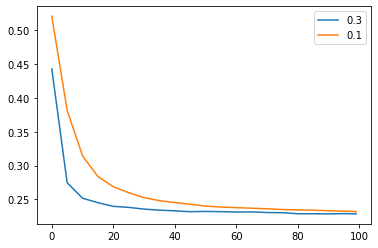

In [67]:
plt.plot(scores_3.num_iter, scores_3.val_auc, label = '0.3')
plt.plot(scores_1.num_iter, scores_1.val_auc, label = '0.1')
plt.legend()